# Iterate maps modeled in Pytorch Apple M1 (Metal) GPU


In [1]:
import math
import time
from types import SimpleNamespace
from tqdm import tqdm
import wandb

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import utils.iterated_map_utils as map_utils
import utils.ode_utils as ode_utils
import utils.torch_utils as torch_utils

## Lorentz attractor

In 1963, Edward Lorenz developed a simple mathematical model of the way air moves around in the atmosphere.
His model was a system of three ordinary differential equations that demonstrates deterministic chaos at certain parameter values and initial conditions. The Lorenz attractor is the system's strange attractor that resembles a butterfly when visualized.

The Lorenz system is nonlinear, three-dimensional, and deterministic. 

The Lorenz attractor is a set of chaotic solutions of the Lorenz system and is possibly the most famous depiction of a system that exibits chaotic behavior. Very slight changes to the initial conditions of the system lead to wildly different solutions. The system itself describes the movement of a point in a three-dimensional space over time using three ordinary differential equations that represent the movement of this point (x, y, z). In these equations, t represents time and sigma, rho, and beta are constant system parameters.

$$ \frac{dx}{dt} = \sigma (y - x) $$

$$ \frac{dy}{dt} = x (\rho - z) - y $$

$$ \frac{dz}{dt} = x y - \beta z $$

For his famous depiction of chaos, Lorenz used the values sigma = 10, beta = 8/3 and rho = 28. With these parameter values, the system exhibits deterministic chaos. It has a strange attractor with a fractal structure.

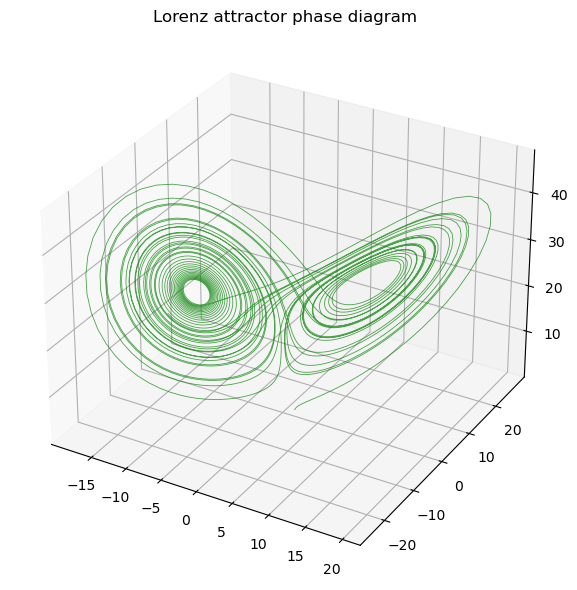

In [2]:
# parameters P and variable vector V
P = {'sigma': 10, 'beta': 8/3, 'rho': 28, 'dt': 0.01, 'n': 4000}
V = [1.5, 0.6, 0.7]
# trajectory T
T = ode_utils.iterate(ode_utils.lorentz_ode, V, **P)
# extract the individual arrays of x, y, and z values from the array of arrays
x, y, z = tuple(T.T)

# plot the lorenz attractor in three-dimensional phase space
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.plot(x, y, z, color='g', alpha=0.7, linewidth=0.6)
ax.set_title('Lorenz attractor phase diagram')
# fig.savefig('{}/lorenz-attractor-3d.png'.format(save_folder), dpi=180, bbox_inches='tight')
plt.tight_layout()
# plt.show()

## Model and train



In [3]:
class RecurrenceModel(nn.Module):

    def name(self):
        return self._get_name()

    def __init__(self, hidden_units_list: list, activation_function='relu'):
        super(RecurrenceModel, self).__init__()
        
        if hidden_units_list[0]!=hidden_units_list[-1]:
            raise ValueError(f'number of input ({hidden_units_list[0]}) and output features ({hidden_units_list[-1]}) must be the same for Recurrence model {hidden_unit_list}')

        self.num_layers = len(hidden_units_list)-1
        self.activation_func = getattr(F, activation_function)

        print(f'using {activation_function} activation function')

        for layer_num, in_features, out_features in zip(range(self.num_layers), hidden_units_list, hidden_units_list[1:]):
            layer = nn.Linear(in_features, out_features, bias=True)
            setattr(self, f'fc{layer_num}', layer)

    def forward(self, x):
        for layer_num in range (self.num_layers):
            layer = getattr(self, f'fc{layer_num}')
            
            if layer_num < self.num_layers -1:
                x = self.activation_func(layer(x))
            else:
                #last layer has no activation function    
                x = layer(x)
        return x


class Model3N3(nn.Module):

    def name(self):
        return self._get_name()

    def __init__(self, num_hidden_units):
        super(Model3N3, self).__init__()

        self.fc1 = nn.Linear(3, num_hidden_units, bias=True)
        # self.fc2 = nn.Linear(num_hidden_units, num_hidden_units)
        self.fc3 = nn.Linear(num_hidden_units, 3, bias=True)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# m = RecurrenceModel([3,2,3], 'leaky_relu')


In [4]:
def train(config, device):
    start = time.time()
    torch_utils.reset_seed(config.seed)

    # create mesh train data (x, y, z)
    # n_steps = int(config.num_samples**(1./3.))
    # x = np.linspace(-30., 30., n_steps)
    # y = np.linspace(-30., 30., n_steps)
    # z = np.linspace(0., 50., n_steps)
    # # create 3D meshgrid of x, y, z
    # X_train = np.vstack(np.meshgrid(x,y,z)).reshape(-1,3)

    # create random distributed train dataset
    mu, sigma = 0, 30 # mean and standard deviation
    x = np.random.normal(mu, sigma, config.num_samples)
    y = np.random.normal(mu, sigma, config.num_samples)
    mu, sigma = 25, 25 # mean and standard deviation
    z = np.random.normal(mu, sigma, config.num_samples)

    X_train = np.vstack((x,y,z)).T.reshape(-1,3)
    # shuffle
    # np.take(X_train, np.random.rand(X_train.shape[0]).argsort(), axis=0, out=X_train)

    # get the target values Y
    Y_train = ode_utils.rk4(ode_utils.lorentz_ode, X_train, t=1.0, **config.parameters)

    # put X and Y in dataset, suited for Apple M1 GPU (Mps)
    train_dataset = torch_utils.MpsDataset(X_train, Y_train, device)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)

    # init model
    # model = Model3N3(config.num_hidden_units)
    model = RecurrenceModel(config.hidden_units_list, config.activation_function)
    model.to(config.device)

    # Make the loss and optimizer
    # loss_fn = torch.nn.MSELoss(reduction='sum')
    loss_fn = torch.nn.MSELoss(reduction='mean')

    if hasattr(config, 'weight_decay'):
        optimizer = torch.optim.Adam(params=model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    else:
        optimizer = torch.optim.Adam(params=model.parameters(), lr=config.learning_rate)

    train_loss=[]
    # train_accuray=[]
    test_loss=[]

    example_ct = 0
    for epoch in range(config.epochs):
        with tqdm(train_loader, unit=" batch") as tepoch:
            for step, (X, Y) in enumerate(tepoch):
                tepoch.set_description(f"Epoch {epoch+1}/{config.epochs}")
                
                X, Y = X.to(device=config.device), Y.to(device=config.device)
                optimizer.zero_grad()
                Y_hat = model(X)
                # loss = loss_fn(Y_hat, Y)
                loss = torch.sqrt(loss_fn(Y_hat, Y))
                loss.backward()
                optimizer.step()

                # correct = (abs(Y_hat - Y)<0.01).sum().item()
                # accuracy = correct / config.batch_size

                example_ct += len(Y)
                tepoch.set_postfix(loss=loss.item(), examples=f'{round(example_ct/1000, 0)}K')

                wandb.log({"loss": loss})
                train_loss.append(loss.item())
                
                # wandb.log({"accuracy": accuracy})
                # train_accuray.append(accuracy)
        
        _, _, test_loss = test(model, config)
        wandb.log({"test_loss": test_loss})

    # calculate timesteps for the ODE trajectory
    n_steps_per_epoch = math.ceil(len(train_loader.dataset) / config.batch_size)
    epoch_time = [x/n_steps_per_epoch for x in range(len(train_loss))]

    end = time.time()
    wandb.log({"total_train_examples": example_ct})
    print(f'training time: {end - start: .2f} sec')

    return model, epoch_time, train_loss


def test(model, config):
    P = config.parameters
    x0 = [1.5, 0.6, 0.7]

    X = ode_utils.iterate(ode_utils.lorentz_ode, x0, n=3501, **P)
    Y_dot = X[1:,:]
    X = X[:-1,:]

    X_torch = torch.tensor(X, dtype=torch.float32).to(config.device)
    Y_hat = model(X_torch)
    Y_hat = Y_hat.cpu().detach().numpy()

    rmse_loss = np.sqrt(np.mean((Y_hat-Y_dot)**2))

    wandb.log({"test_loss": rmse_loss})

    return Y_dot, Y_hat, rmse_loss
    

## Config

In [5]:
config = SimpleNamespace(
    # reproducability
    seed=33,
    
    # train model
    model_name="RecurrenceModel",
    hidden_units_list = [3,4,3],
    activation_function = 'relu',
    
    # train regime
    batch_size=32,  # 32 better than 64 better than 128
    epochs=6,

    # train data
    dataset="np.random.normal([x:0,30, y:0,30, z:25,25], num_samples)",
    map_name="lorentz_ode",
    parameters = {'sigma': 10, 'beta': 8/3, 'rho': 28, 'dt': 0.01},
    num_samples = 20**3,  # 30**3 better than 40**3
    
    optimizer="Adam",
    learning_rate=50e-3,  # 2e-2
    weight_decay=50e-2,  # 1e-2
    loss_fuc="RMSE",

    # device
    device="mps",
    dtype="float32",
    # num_workers=4,
    gpu_name="M1Pro GPU 16 Cores",
)

run = wandb.init(project="iterate-lorentz-tm-v0.2", config=config)

device  = torch_utils.get_device()
model, epoch_time, train_loss = train(config, device)

Y_dot, Y_hat, test_loss = test(model, config)

run.finish()

wandb: Currently logged in as: bart-marseille. Use `wandb login --relogin` to force relogin


pytorch using device: mps
using relu activation function


Epoch 6/6: 100%|██████████| 250/250 [00:04<00:00, 59.98 batch/s, examples=48.0K, loss=10.7]


training time:  21.55 sec


loss,█▃▁▂▁▃▄▁▃▂▂▂▂▃▁▂▂▂▃▁▃▃▂▃▃▁▂▁▃▂▂▂▂▂▃▁▃▄▃▂
test_loss,██▆▆▅▅▃▃▁▁▂▂▂
total_train_examples,▁
loss,10.65279
test_loss,1.40042
total_train_examples,48000


## Visualize loss

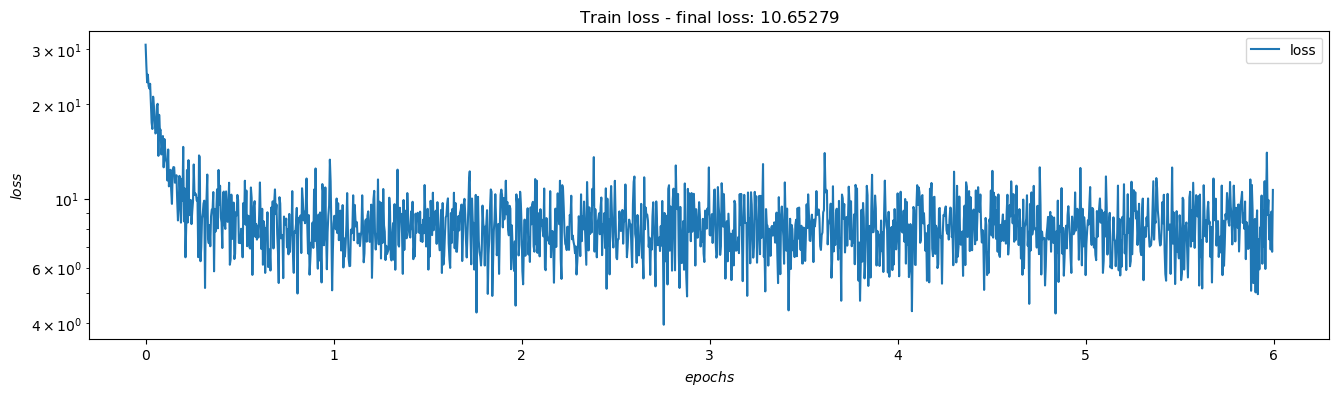

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(epoch_time, train_loss, label='loss')
# ax.plot(epoch_time, train_accuracy, label='accuracy')
ax.set_title(f'Train loss - final loss: ${train_loss[-1]: .5f}$')
ax.set_xlabel('$epochs$')
ax.set_ylabel('$loss$')
ax.set_yscale('log')
ax.legend(loc="upper right")
plt.show()

## Visualize actual vs predicted

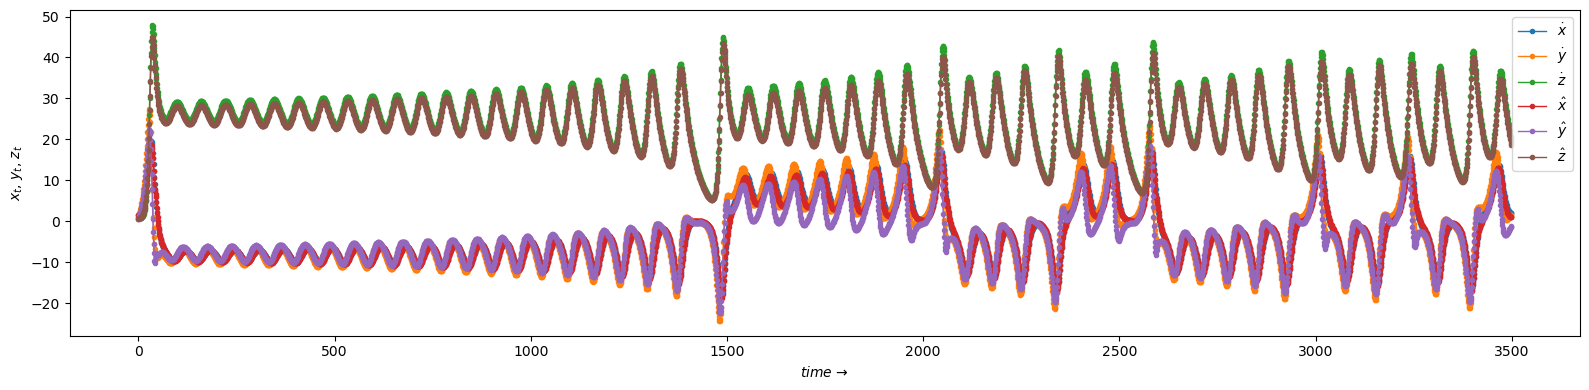

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize=(16, 4))  #, gridspec_kw={'width_ratios': [3, 1]}, sharey=True)

ax1.plot(Y_dot, marker='.', lw=1, label=['$\dot{x}$', '$\dot{y}$', '$\dot{z}$'])
ax1.plot(Y_hat, marker='.', lw=1, label=['$\hat{x}$', '$\hat{y}$', '$\hat{z}$'])

ax1.set_xlabel(f'$time$ $→$')
ax1.set_ylabel(f'$x_t$, $y_t$, $z_t$')
# ax1.legend(loc="upper left")
ax1.legend()

plt.tight_layout()

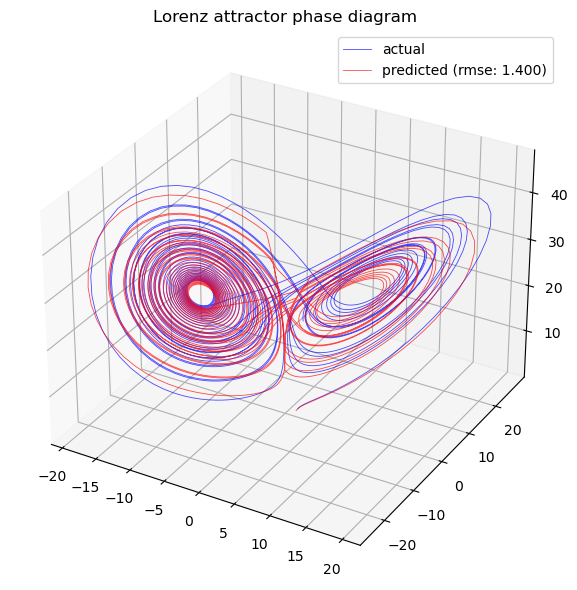

In [8]:
x_dot, y_dot, z_dot = tuple(Y_dot.T)
x_hat, y_hat, z_hat = tuple(Y_hat.T)

rmse_loss = np.sqrt(np.mean((Y_hat-Y_dot)**2))

# plot the lorenz attractor in three-dimensional phase space
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.plot(x_dot, y_dot, z_dot, color='b', alpha=0.7, linewidth=0.6, label='actual')
ax.plot(x_hat, y_hat, z_hat, color='r', alpha=0.7, linewidth=0.6, label=f'predicted (rmse: {rmse_loss:.3f})')
ax.set_title('Lorenz attractor phase diagram')
ax.legend()

# fig.savefig('{}/lorenz-attractor-3d.png'.format(save_folder), dpi=180, bbox_inches='tight')
plt.tight_layout()

## In progress - reading model parameters

In [9]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
num_params = sum([np.prod(p.size()) for p in model_parameters])
print(model)
print(f'num_params: {num_params}')

RecurrenceModel(
  (fc0): Linear(in_features=3, out_features=4, bias=True)
  (fc1): Linear(in_features=4, out_features=3, bias=True)
)
num_params: 31


In [11]:
# for param in model.parameters():
#     if param.requires_grad:
#         print(param)

# print('\n')

# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(f'{name}: {param.cpu().detach().numpy().flatten()}')